# Setting up Colab environment

In [ ]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

## Main imports

In [51]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold

from polara import get_movielens_data
from polara.tools.display import print_frames

# Task

Develop a recommender systems framework for conducting the necessary experiments, which includes:
- training recsys models
- generating recommendations
- evaluating recommendations quality
- performing model comparison

## Experiment protocol can be described in terms of 4 functions:

```python
# building/training a recommender model
model_params = build_func(model_config, trainset, trainset_description)

# predicting relevance scores for test user-item pairs
model_scores = score_func(model_params, testset, testset_description)

# generating top-n recommendations using predcted scores
model_recoms = recom_func(model_scores, topn)

# evaluating quality of recommendations
recs_quality = evaluate_func(model_recoms, holdout, holdout_description)
```


**Essentially, this is the main functionality provided by most of the recommender systems frameworks.** That's why we can say that we're building a simple recsys framework from scratch.

# Data Preparation

## Downloading

We use `polara`'s function to download [Movielens-1M](https://files.grouplens.org/datasets/movielens/ml-1m.zip) dataset:

In [2]:
data, genres = get_movielens_data(
    get_genres=True,
    split_genres=False,
    include_time=True
)

In [3]:
data.head()

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movies = genres.set_index('movieid')
movies.head()

,movienm,genres
movieid,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


## Viewing basic data stats

In [5]:
data.apply('nunique')

userid         6040
movieid        3706
rating            5
timestamp    458455
dtype: int64

### Ratings distribution:

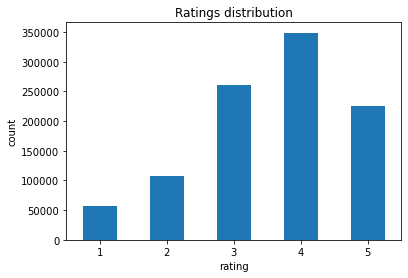

In [6]:
(
    data["rating"]
    .value_counts()
    .sort_index()
    .plot.bar(
        title='Ratings distribution',
        xlabel='rating', ylabel='count',
        rot=0
    )
);

### Evolution of movies popularity

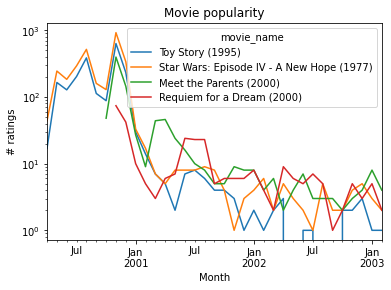

In [42]:
select_movies = [1, 260, 3948, 3949]
(
    data
    .set_index(pd.to_datetime(data['timestamp'], unit='s'))
    .query('movieid in @select_movies')
    .assign(movie_name=lambda x: x['movieid'].map(movies['movienm']))
    .groupby('movie_name', sort=False)
    .resample('M') # monthly
    .size() # total count
    .unstack(level='movie_name')
    .plot(logy=True, title='Movie popularity', xlabel='Month', ylabel='# ratings')
);

# Preprocess data

Here, we'll use a simple (non-temporal) user-wise "leave-last-out" scheme for holdout sampling.  
Note that this scheme is not perfect as it's prone to test data leakage from future interactions. We'll deal with it later.

## Data split

In [55]:
def leave_last_out(data, userid='userid', timeid='timestamp'):
    sorted = data.sort_values(timeid)
    holdout = sorted.drop_duplicates(subset=[userid], keep='last')
    remaining = data.drop(holdout.index)
    return remaining, holdout

In [56]:
training_, holdout_ = leave_last_out(data)

Check that splits do not violate the splitting rule:

In [57]:
assert holdout_.set_index('userid')['timestamp'].ge(
    training_
    .groupby('userid')
    ['timestamp'].max()
).all()

## Transform index

Source data is not always numeric. Moreover, user and item ids may contain large gaps. We fix that by introducing an internal contiguous numeric index.


In [58]:
def transform_indices(data, users, items):
    data_index = {}
    for entity, field in zip(['users', 'items'], [users, items]):
        idx, idx_map = to_numeric_id(data, field)
        data_index[entity] = idx_map
        data.loc[:, field] = idx # inplace operation!
    return data, data_index

def to_numeric_id(data, field):
    idx_data = data[field].astype("category")
    idx = idx_data.cat.codes
    idx_map = idx_data.cat.categories.rename(field)
    return idx, idx_map

def reindex_data(data, entity, data_index):
    field = data_index[entity].name
    new_index = data_index[entity].get_indexer(data[field])
    return data.assign(**{f'{field}': new_index})

In [59]:
# build new index and 
training, data_index = transform_indices(training_, 'userid', 'movieid')

In [60]:
print_frames([training.head(), data.head()])

,userid,movieid,rating,timestamp
0,0,1104,5,978300760
1,0,639,3,978302109
2,0,853,3,978301968
3,0,3175,4,978300275
4,0,2161,5,978824291
,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275


In [61]:
# apply new index to holdout
holdout = reindex_data(holdout_, 'items', data_index)

## Data consistency check

We need to ensure that holdout doesn't contain entities that are not present in the training data.
As we use `pandas` `get_indexer` function, the uknown indices will be replaced with -1 (the default).

In [64]:
holdout.query('movieid<0')

,userid,movieid,rating,timestamp
6448,46,-1,5,977979487
304604,1812,-1,3,1036451763


In [17]:
holdout = holdout.query('movieid >= 0')

# Random recommendations model

We have the dataset for simple evaluation ready. Let's build simple recommenders to complete the pipeline.

In [65]:
def build_random_model(config, trainset, trainset_description):
    itemid = trainset_description['items']
    n_items = trainset[itemid].max() + 1
    random_state = np.random.RandomState(config['seed'])
    return n_items, random_state

In [66]:
def random_model_scoring(params, testset, testset_description):
    n_items, random_state = params
    n_users = testset_description['n_test_users']
    scores = random_state.rand(n_users, n_items)
    return scores

In [67]:
def simple_model_recom_func(scores, topn=10):
    recommendations = np.apply_along_axis(topidx, 1, scores, topn)
    return recommendations

def topidx(a, topn):
    parted = np.argpartition(a, -topn)[-topn:]
    return parted[np.argsort(-a[parted])]

In [68]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    n_test_users = holdout[data_index['users'].name].nunique()
)

In [69]:
rnd_params = build_random_model({'seed': 99}, training, data_description)
rnd_scores = random_model_scoring(rnd_params, None, data_description)
rnd_recoms = simple_model_recom_func(rnd_scores)

In [70]:
def display_movies(items_idx):
    # need to convert internal index to external representation
    movie_idx = data_index['items'][items_idx]
    return movies.loc[movie_idx]

In [74]:
test_user_id = 0
display_movies(rnd_recoms[test_user_id])

,movienm,genres
movieid,,
2440,Another Day in Paradise (1998),Drama
1665,Bean (1997),Comedy
3820,Thomas and the Magic Railroad (2000),Children's
2092,"Return of Jafar, The (1993)",Animation|Children's|Musical
290,Once Were Warriors (1994),Crime|Drama
731,Heaven's Prisoners (1996),Mystery|Thriller
371,"Paper, The (1994)",Comedy|Drama
3804,H.O.T.S. (1979),Comedy
1005,D3: The Mighty Ducks (1996),Children's|Comedy


# Simple popularity-based model


In [75]:
def build_popularity_model(config, trainset, trainset_description):
    itemid = trainset_description['items']
    item_popularity =  ... # <- your code here
    return item_popularity

In [76]:
def popularity_model_scoring(params, testset, testset_description):
    item_popularity = params
    n_items = item_popularity.index.max() + 1
    n_users = testset_description['n_test_users']
    # fill in popularity scores for each item with indices from 0 to n_items-1
    popularity_scores = np.zeros(n_items,)
    popularity_scores[item_popularity.index] = item_popularity.values
    # same scores for each test user
    scores = np.tile(popularity_scores, n_users).reshape(n_users, n_items)
    return scores

In [77]:
pop_params = build_popularity_model({}, training, data_description)
pop_scores = popularity_model_scoring(pop_params, None, data_description)
pop_recoms = simple_model_recom_func(pop_scores)

In [80]:
test_user_id = 2
display_movies(pop_recoms[test_user_id])

,movienm,genres
movieid,,
2858,American Beauty (1999),Comedy|Drama
1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
480,Jurassic Park (1993),Action|Adventure|Sci-Fi
2028,Saving Private Ryan (1998),Action|Drama|War
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1270,Back to the Future (1985),Comedy|Sci-Fi


### Your home task:
- Implement a simple item-to-item algorithm and generate recommendations with it. You will neeed to define 2 functions:
  - `i2i_build_func` for preparing model,
  - `i2i_score_func` for generating scores.
- Compare you model to the baselines using simple metrics (described in the next section).

# Evaluating recommendations quality

We will use **HitRate** (HR) и **Mean Reciprocal Rank** (MRR).  
*Note*: In the case of a single holdout item per user the latter coincides with the Average Reciprocal HitRate (ARHR) and Mean Average Precision (MAP).

$$
\text{HR} = \frac{1}{\text{\# test users}} \sum_{\text{test users}}{hit}, \quad
$$

$$
hit = 
\begin{gather*}
\begin{cases}
  1 & \text{if holdout item in top-$n$ recommendations,}\\    
  0 & \text{otherwise.}
\end{cases}
\end{gather*}
$$

$$
\text{MRR} = \frac{1}{\text{\# test users}} \sum_{\text{test users}}{\frac{1}{\text{hit rank}}}
$$

Our holdout is simply a 1d array. We can use `numpy`'s broadcasting feature to quickly assess whether there are any hits in the generated recommendations.

In [81]:
rnd_hits_mask = (rnd_recoms == holdout['movieid'].values.reshape(-1, 1))

The mask indicates whether there is a hit (`True` value) per row. Each row corresponds to a specific test user.  
The final metric is then computed via averaging over all rows.

In [86]:
hit_per_user = rnd_hits_mask.any(axis=1)
rnd_hr = np.mean(hit_per_user)
print(f'{rnd_hr=:.4f}')

rnd_hr=0.0013


In [87]:
_, rnd_hits_rank = np.where(rnd_hits_mask)

In [88]:
n_test_users = holdout.shape[0]
rnd_mrr = np.sum(1 / (rnd_hits_rank+1.)) / n_test_users
print(f'{rnd_mrr=:.4f}')

rnd_mrr=0.0004


Let's pack it into the function:

In [93]:
def model_evaluate(recommended_items, holdout, holdout_description, topn=10):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    assert recommended_items.shape[0] == len(holdout_items)
    hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    # MRR calculation
    n_test_users = recommended_items.shape[0]
    _, hit_rank = np.where(hits_mask)
    mrr = np.sum(1. / (hit_rank +  1)) / n_test_users
    return hr, mrr

In [94]:
model_evaluate(rnd_recoms, holdout, data_description)

(0.0013245033112582781, 0.00037823241879533266)

In [95]:
model_evaluate(pop_recoms, holdout, data_description)

(0.020364238410596026, 0.007024663618206664)

<font color=green>  

* The obtained results are metrics@<...>?
* What is the obvious way of improving the obtained results? Hint: we miss something in our scoring functions.
* How do we get confidence intervals and estimate statistical significance of the results?  
* What requirements our models would have to satisfy?
* What changes do we need to make in order to assess strong generalization?

</font>

# Cross-validation example

Let's assume there's no dependence of user consumption pattern on time data (or at leastwe ar not interested in it). In that case, temporal splitting is not necessary and we can switch to e.g. random sampling strategy. 

Our methodology will be:
- random "leave-one-out" sampling for holdout items
- use $k$-fold cross-validation scheme,
- test against strong generalization of models.

## CV boilerplate

### data preparation routines

In [96]:
def leave_one_out(data, data_descirption, seed=None):
    shuffled = data.sample(frac=1, random_state=seed)
    holdout = shuffled.drop_duplicates(subset=[data_descirption['users']], keep='last')
    remaining = data.drop(holdout.index)
    return remaining, holdout

def train_test_split(test_index, data, data_description, seed, holdout_sampling=None):
    userid = data_description['users']
    itemid = data_description['items']
    if holdout_sampling is None:
        holdout_sampling = leave_one_out
    # split train/test and build internal index
    test_data_ = data.iloc[test_index]
    training_ = data.drop(test_data_.index)
    training, data_index = transform_indices(training_, userid, itemid)
    # conform test data with internal index
    test_data = (
        reindex_data(test_data_, 'items', data_index)
        .query(f'{itemid} >= 0')
    )
    # note: we haven't reindexed user ids in our simple example
    # but in general we need to perform user reindexing as well

    # split holdout
    testset, holdout = holdout_sampling(test_data, data_description, seed=seed)
    # ensure user index consistency in test data
    # due to warm-start condition, we don't need to check
    # for consistency with the training data
    same_test_users = testset[userid].isin(holdout[userid])
    if not same_test_users.all():
        testset = testset[same_test_users]
    # sort by users for convenience and conformity
    testset = testset.sort_values(userid)
    holdout = holdout.sort_values(userid)
    return training, testset, holdout, data_index

### CV routines

In [97]:
metrics = ['HR', 'MRR']

In [103]:
def run_kfold_cv(
    data, data_description,
    models, configs,
    build_funcs, score_funcs,
    recom_func, eval_func,
    *,
    k_folds=5,
    topn_list=None,
    seed=None,
    fold_experiment=None,
    **kwargs
): 
    # perform basic checks
    assert len(configs) == len(models) == len(build_funcs) == len(score_funcs)
    if fold_experiment is None:
        fold_experiment = run_fold_experiment
    if topn_list is None:
        topn_list = [10]
    # initiate experiment
    kfold = GroupKFold(n_splits=k_folds)
    user_groups = data[data_description['users']]
    results = []
    for train_idx, test_idx in tqdm(kfold.split(data, groups=user_groups), total=k_folds):
        fold_data = train_test_split(test_idx, data, data_description, seed)
        fold_res = fold_experiment(
            fold_data, data_description,
            models, configs,
            build_funcs, score_funcs,
            recom_func, eval_func,
            topn_list,
            **kwargs
        )
        results.append(fold_res)
    return results


def run_fold_experiment(
    fold_data, data_description,
    models,  configs,
    build_funcs, score_funcs,
    recom_func, eval_func,
    topn_list
):
    fold_results = {model: {metric: [] for metric in metrics} for model in models}
    topn_max = max(topn_list)
    # unpack experiment data
    training, testset, holdout, data_index = fold_data
    testset_description = {
        **data_description,
        'n_test_users': testset[data_description['users']].nunique()
    }
    # run experiment
    for model, build_func, score_func, model_config in zip(models, build_funcs, score_funcs, configs):
        model_params = build_func(model_config, training, data_description)
        model_scores = score_func(model_params, testset, testset_description)
        model_recoms = recom_func(model_scores, topn=topn_max)
        for topn in topn_list:
            hr, mrr = eval_func(model_recoms, holdout, data_description, topn=topn)
            fold_results[model]['HR'].append(hr)
            fold_results[model]['MRR'].append(mrr)
    return fold_results

## run experiment

In [104]:
model_names = ['most popular', 'random']
model_configs = [{}, {'seed': 0}]
model_build_funcs = [build_popularity_model, build_random_model]
models_scoring = [popularity_model_scoring, random_model_scoring]
topn_list = [1, 5, 10]

results = run_kfold_cv(
    data, data_description,
    model_names, model_configs,
    model_build_funcs, models_scoring,
    simple_model_recom_func, model_evaluate,
    k_folds=4, topn_list=topn_list
)

100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


# Results analysis

In [108]:
def results_to_df(results, topn_list):
    metric_index = pd.MultiIndex.from_product(
        [metrics, topn_list],
        names=['metric', 'topn']
    )
    results_df = pd.concat(
        {
            foldid: pd.DataFrame(res)
            .explode(column=list(res.keys()))
            .set_index(metric_index)
            for foldid, res in enumerate(results, start=1)
        },
        names=['fold']
    )
    return results_df

In [109]:
results_df = results_to_df(results, topn_list)
results_df.head(10)

most popular    random
fold metric topn                       
1    HR     1         0.00596       0.0
            5        0.025828  0.001325
            10       0.045695  0.001987
     MRR    1         0.00596       0.0
            5        0.012561  0.000331
            10       0.015166  0.000426
2    HR     1        0.007947       0.0
            5        0.028477  0.000662
            10       0.043046  0.000662
     MRR    1        0.007947       0.0

In [114]:
results_df.groupby(level=['metric', 'topn']).mean()

most popular    random
metric topn                        
HR     1         0.007119  0.000166
       5         0.025828  0.000993
       10        0.045033  0.001821
MRR    1         0.007119  0.000166
       5         0.013311  0.000442
       10        0.015840  0.000546

<font color=green>

- Do we actually measure user satisfaction with the implemented sampling? Why?
- Suggest an evaluation protocol to measure potential satisfaction better.

</font>

# Significance test

In [116]:
from polara.evaluation.evaluation_engine import sample_ci

In [ ]:
pd.DataFrame.stack

In [120]:
sample_ci(results_df.unstack('metric'), level='topn')

most popular              random          
metric           HR       MRR        HR       MRR
topn                                             
1          0.001379  0.001379  0.000460  0.000460
5          0.002600  0.001437  0.000531  0.000415
10         0.002907  0.001315  0.001157  0.000459

# Helpers

In [ ]:
def downvote_seen_items(scores, data, data_description):
    itemid = data_description['items']
    userid = data_description['users']
    # get indices of observed data
    sorted = data.sort_values(userid)
    item_idx = sorted[itemid].values
    user_idx = sorted[userid].values
    user_idx = np.r_[False, user_idx[1:] != user_idx[:-1]].cumsum()
    # downvote scores at the corresponding positions
    seen_idx_flat = np.ravel_multi_index((user_idx, item_idx), scores.shape)
    np.put(scores, seen_idx_flat, scores.min() - 1)